<a href="https://colab.research.google.com/github/TNTTNTTTN/Titanic_Survive_Prediction/blob/main/term_project_code_17011266_%EC%9D%B4%EC%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [221]:
#-*- coding: utf-8 -*-
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

seed = 3
np.random.seed(seed)
tf.random.set_seed(seed)

df = pd.read_csv("/content/train.csv")
stscaler = StandardScaler()
mmscaler = MinMaxScaler()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [222]:
def get_title(Name):
  if 'Mrs' in Name or 'Mme' in Name :
    Title='Mrs'
  elif 'Mr' in Name or 'Sir' in Name :
    Title='Mr'
  elif 'Miss' in Name or 'Ms' in Name or 'Mlle' in Name:
    Title='Miss'
  elif 'Master' in Name:
    Title='Master'
  else:
    Title='Else'
  return Title

In [223]:
def classify_age(Age):
  if Age<=10 : tag ="0"
  elif Age <=20 : tag="1"
  elif Age <= 30 : tag="2"
  elif Age <= 40 : tag="3"
  elif Age <= 50 : tag="4"
  elif Age <= 60 : tag ="5"
  else : tag = "6"
  return tag

In [224]:
def classify_fare(Fare):
  if Fare <= 75 : tag="0"
  elif Fare <= 150 : tag=""
  elif Fare <= 225 : tag="2"
  elif Fare <= 300 : tag="3"
  elif Fare <= 375 : tag="4"
  elif Fare <= 450 : tag="5"
  else : tag = "6"
  return tag

In [225]:
df['Title'] = df['Name'].apply(lambda x : get_title(x))
df['Pclass'] = df['Pclass'].astype('string')
#title_dic = {"Mrs":0, "Mr":1, "Miss":2, "Master":3, "Else":4}
#df['Title'] = df['Title'].map(title_dic).astype(int).fillna(0)

In [226]:
#df['Sex'] = df['Sex'].map({'male':0, 'female':1}).astype(int)
df.loc[(df['Sex']=='male') & (df['Age'].isnull()) & (df['Title']==3),'Age'] = 10
df.loc[(df['Sex']=='male') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='male']['Age'].mean()
df.loc[(df['Sex']=='female') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='female']['Age'].mean()
#df['Age'] = df['Age'].apply(lambda x : classify_age(x))

In [227]:
df.loc[(df['Pclass']==1) & (df['Cabin'].isnull()),'Cabin'] = 'C'
df.loc[(df['Pclass']==2) & (df['Cabin'].isnull()),'Cabin'] = 'E'
df.loc[(df['Pclass']==3) & (df['Cabin'].isnull()),'Cabin'] = 'F'

In [228]:
cabin_dic={'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
df['Ncabin'] = df['Cabin'].str.extract('([A-G])', expand=False)
df['Ncabin'] = df['Ncabin'].fillna("N")

In [229]:
df['Family'] = df['SibSp']+df['Parch']
df.loc[df['Family'] > 3,'Family'] = 4
df['Family'] = df['Family'].astype('string')

In [230]:
embark_dic = {0:"C", 1:"S", 2:"Q"}
df['Embarked'].fillna(df['Embarked'].dropna().mode()[0], inplace=True)
for i in range(3):
  df.loc[(df['Pclass']==i+1) & (df['Fare'].isnull()),'Fare'] = df[df['Pclass']==i+1]['Fare'].dropna().median()
#df['Fare'].fillna(df['Fare'].dropna().median(), inplace=True)
#df['Fare'] = df['Fare'].apply(lambda x : classify_fare(x))

In [231]:
df.loc[df['Fare'].isnull(),'Fare'] = df[df['Embarked']==embark_dic[1]]['Fare'].mean()

In [232]:
df[df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ncabin,Family


In [233]:
df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

KeyboardInterrupt: ignored

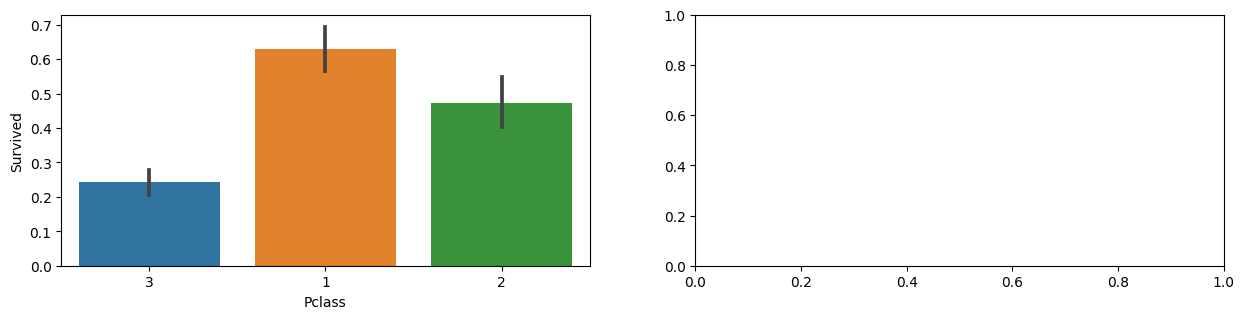

In [209]:
plt.figure(figsize=(15,15))
plt.subplot(4,2,1)
sns.barplot(x='Pclass', y='Survived', data=df)
plt.subplot(4,2,2)
sns.barplot(x='Fare', y='Survived', data=df)
plt.subplot(4,2,3)
sns.barplot(x='Title', y='Survived', data=df)
plt.subplot(4,2,4)
sns.barplot(x='Family', y='Survived', data=df)
plt.subplot(4,2,5)
sns.barplot(x='Embarked', y='Survived', data=df)
plt.subplot(4,2,6)
sns.barplot(x='Age', y='Survived', data=df)

In [234]:
df.drop(['PassengerId','Name', 'Cabin', 'Ticket', 'SibSp','Parch'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    string 
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   Fare      891 non-null    float64
 5   Embarked  891 non-null    object 
 6   Title     891 non-null    object 
 7   Ncabin    891 non-null    object 
 8   Family    891 non-null    string 
dtypes: float64(2), int64(1), object(4), string(2)
memory usage: 62.8+ KB


In [235]:
stscaler.fit(df[['Age','Fare']])
scaled = stscaler.transform(df[['Age','Fare']])
mmscaler.fit(scaled)
output = mmscaler.transform(scaled)
output = pd.DataFrame(output, columns=['Age','Fare'])
df['Age'] = output['Age']
df['Fare'] = output['Fare']
#df['Ncabin'] = df['Ncabin'].astype(int)

In [236]:
data = ['Pclass','Sex','Embarked','Title','Ncabin','Family']
#data= ['Ncabin','Family','Title']
for column in data:
  
  le = LabelEncoder()
  le = le.fit(df[column])
  df[column] = le.transform(df[column])
me = MinMaxScaler()
me = me.fit(df[data])
df[data] = me.transform(df[data])

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    float64
 2   Sex       891 non-null    float64
 3   Age       891 non-null    float64
 4   Fare      891 non-null    float64
 5   Embarked  891 non-null    float64
 6   Title     891 non-null    float64
 7   Ncabin    891 non-null    float64
 8   Family    891 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 62.8 KB


In [214]:
#Survive = df.iloc[:,0]
#df = pd.get_dummies(df.iloc[:,1:])
df = pd.get_dummies(df,drop_first=True)
#df = pd.concat([Survive, df],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Age         891 non-null    float64
 2   Fare        891 non-null    float64
 3   Title       891 non-null    float64
 4   Ncabin      891 non-null    float64
 5   Family      891 non-null    float64
 6   Pclass_2    891 non-null    uint8  
 7   Pclass_3    891 non-null    uint8  
 8   Sex_male    891 non-null    uint8  
 9   Embarked_Q  891 non-null    uint8  
 10  Embarked_S  891 non-null    uint8  
dtypes: float64(5), int64(1), uint8(5)
memory usage: 46.2 KB


In [237]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Ncabin,Family
0,0,1.0,1.0,0.271174,0.014151,1.0,0.75,1.000000,0.25
1,1,0.0,0.0,0.472229,0.139136,0.0,1.00,0.285714,0.25
2,1,1.0,0.0,0.321438,0.015469,1.0,0.50,1.000000,0.00
3,1,0.0,0.0,0.434531,0.103644,1.0,1.00,0.285714,0.25
4,0,1.0,1.0,0.434531,0.015713,1.0,0.75,1.000000,0.00


In [238]:
dataset = df.values
X = dataset[:,1:]
Y = dataset[:,0]
n_fold = 5
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=3)
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
accuracy =[]

In [240]:
from keras import regularizers

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50)
#history = model.fit(X_train, Y_train, validation_split=0.2, epochs=1000, batch_size=5, verbose=1, 
#          callbacks=[early_stopping_callback])
#model.fit(X, Y, validation_split=0.2, epochs=1000, batch_size=5, verbose=1, 
#         callbacks=[early_stopping_callback])
for train, test in skf.split(X, Y):
    model = Sequential()
    model.add(Dense(16, input_dim=8, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    #model.add(Dropout(0.25))
    model.add(Dense(4, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    #model.add(Dropout(0.25))
    #model.add(Dense(1, activation='relu'))
    #model.add(Dropout(0.25))
    #model.add(Dense(4, activation='relu'))
    #model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.fit(X[train], Y[train], validation_split=0.2, epochs=500, batch_size=8, callbacks=[early_stopping_callback])
    k_accuracy = "%.4f" % (model.evaluate(X[test], Y[test])[1])
    accuracy.append(float(k_accuracy))
print("\n %.f fold mean accuracy:" % n_fold, sum(accuracy)/n_fold)

Epoch 1/500
72/72 [==============================] - 1s 5ms/step - loss: 0.6977 - accuracy: 0.5325 - val_loss: 0.6291 - val_accuracy: 0.6643
Epoch 2/500
72/72 [==============================] - 0s 2ms/step - loss: 0.6337 - accuracy: 0.6046 - val_loss: 0.5904 - val_accuracy: 0.6643
Epoch 3/500
72/72 [==============================] - 0s 3ms/step - loss: 0.6049 - accuracy: 0.6116 - val_loss: 0.5581 - val_accuracy: 0.6783
Epoch 4/500
72/72 [==============================] - 0s 3ms/step - loss: 0.5781 - accuracy: 0.7100 - val_loss: 0.5351 - val_accuracy: 0.7902
Epoch 5/500
72/72 [==============================] - 0s 3ms/step - loss: 0.5583 - accuracy: 0.7786 - val_loss: 0.5118 - val_accuracy: 0.8182
Epoch 6/500
72/72 [==============================] - 0s 3ms/step - loss: 0.5375 - accuracy: 0.7821 - val_loss: 0.4945 - val_accuracy: 0.8182
Epoch 7/500
72/72 [==============================] - 0s 2ms/step - loss: 0.5249 - accuracy: 0.7821 - val_loss: 0.4841 - val_accuracy: 0.8182
Epoch 8/500
7

In [219]:
accuracy

[0.7989, 0.8596, 0.8034, 0.8427, 0.7528]

In [23]:
model = Sequential()
model.add(Dense(22, input_dim=22, activation='sigmoid'))
#model.add(Dropout(0.25))
#model.add(Dense(1, activation='sigmoid'))
#model.add(Dropout(0.25))
#model.add(Dense(4, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(4, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X, Y, epochs=500, batch_size=8, verbose=1)

Epoch 1/500
112/112 [==============================] - 2s 3ms/step - loss: 0.5511 - accuracy: 0.7441
Epoch 2/500
112/112 [==============================] - 0s 3ms/step - loss: 0.5323 - accuracy: 0.7587
Epoch 3/500
112/112 [==============================] - 0s 3ms/step - loss: 0.5176 - accuracy: 0.7677
Epoch 4/500
112/112 [==============================] - 0s 3ms/step - loss: 0.5050 - accuracy: 0.7699
Epoch 5/500
112/112 [==============================] - 0s 4ms/step - loss: 0.4947 - accuracy: 0.7767
Epoch 6/500
112/112 [==============================] - 1s 6ms/step - loss: 0.4860 - accuracy: 0.7868
Epoch 7/500
112/112 [==============================] - 0s 2ms/step - loss: 0.4788 - accuracy: 0.7912
Epoch 8/500
112/112 [==============================] - 0s 2ms/step - loss: 0.4726 - accuracy: 0.8070
Epoch 9/500
112/112 [==============================] - 0s 2ms/step - loss: 0.4672 - accuracy: 0.8114
Epoch 10/500
112/112 [==============================] - 0s 1ms/step - loss: 0.4622 - accura

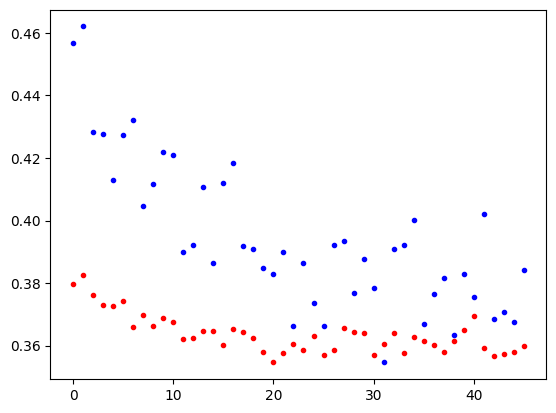

9/9 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.7873

 Accurarcy: 0.7873


In [ ]:
model_vloss = history.history['val_loss'][10:]
model_loss = history.history['loss'][10:]
x_len = np.arange(len(model_loss))

plt.plot(x_len, model_vloss, "o", c="red", markersize=3)
plt.plot(x_len, model_loss, "o", c="blue", markersize=3)
plt.show()

print("\n Accurarcy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

In [24]:
model.save('please.h5')

In [42]:
model = load_model('please.h5')
Y_prediction = model.predict(dataset).flatten()




14/14 [==============================] - 0s 2ms/step


In [ ]:
Y_prediction

array([0.11722659, 0.40866733, 0.13681594, 0.11251757, 0.5664738 ,
       0.11374838, 0.6900107 , 0.13988177, 0.60747606, 0.11481825,
       0.11223755, 0.2993596 , 0.96575564, 0.11716014, 0.963159  ,
       0.94531775, 0.15359524, 0.11568338, 0.454807  , 0.50810957,
       0.30347264, 0.7426298 , 0.9649131 , 0.3965918 , 0.8919366 ,
       0.10958512, 0.9665996 , 0.11549427, 0.3123818 , 0.11667348,
       0.11949418, 0.1411181 , 0.8775627 , 0.8841701 , 0.37016112,
       0.11600801, 0.48376757, 0.51951987, 0.11269774, 0.11256566,
       0.11179957, 0.3391412 , 0.11141827, 0.9330158 , 0.9633191 ,
       0.11268675, 0.34858996, 0.11787211, 0.9637603 , 0.52047   ,
       0.33442774, 0.1406264 , 0.96536756, 0.89758927, 0.13889834,
       0.22128342, 0.11186187, 0.11268483, 0.11072077, 0.9668859 ,
       0.11343455, 0.12869248, 0.11333522, 0.7248919 , 0.95674264,
       0.9333967 , 0.74190456, 0.2997353 , 0.38561237, 0.8127237 ,
       0.7162895 , 0.11304995, 0.4885076 , 0.39224643, 0.96671

In [43]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = Y_prediction
submission.loc[submission['Survived'] < 0.5 ,'Survived'] = 0
submission.loc[submission['Survived'] >= 0.5 ,'Survived'] = 1
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('sub2.csv',index=False)

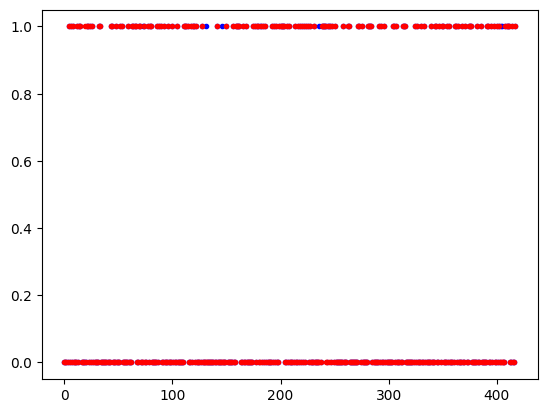

In [ ]:
#Y_prediction = model.predict(X_test).flatten()
osub = pd.read_csv("submit.csv")

Y_pred_old = osub['Survived']

#plt.plot(range(len(Y_test)), Y_test, "o", c="red", markersize=3)
plt.plot(range(len(Y_prediction)), submission['Survived'], "o", c="blue", markersize=3)
plt.plot(range(len(Y_prediction)), Y_pred_old, "o", c='red', markersize=3)
plt.show()

In [ ]:
t = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
pd.DataFrame(t).value_counts()

KeyError: ignored

In [ ]:
df['FBand'] = pd.cut(df['Fare'], 7)
df[['FBand','Survived']].groupby(['FBand'], as_index=False).mean()

In [ ]:
df['Ncabin'] = df['Cabin'].str.extract('([A-G])', expand=False)
pd.crosstab(df['Ncabin'],df['Survived'])

In [ ]:
df[['Embarked','Fare']].groupby(['Embarked'], as_index=False).mean()
df[['Pclass','Fare']].groupby(['Pclass'], as_index=False).mean()

In [ ]:
df.info()
df[df['Embarked'].isnull()]

In [ ]:

df[['Ncabin','Survived']].groupby('Ncabin').mean()

In [48]:
submit1 = pd.read_csv('sub1.csv')
submit2 = pd.read_csv('sub2.csv')

In [49]:
submit1[submit1['Survived'] == submit2['Survived']]

,PassengerId,Survived
0,892,0
2,894,0
3,895,0
5,897,0
6,898,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
